# get hourly data for 2019 for single box

In [7]:
import datetime
import pandas as pd
import numpy as np
import requests
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

## define functions

In [2]:
def get_weekly_data(box_id: str,sensor_id:str,week:list):
    """
    - takes box_id, sensor_id and dates specified in week
    - requests data for that sensor in that timeframe from opensensemap
    - return dataframe with values of the sensor for the specified times
    """
    url = ("https://api.opensensemap.org/boxes/" 
           + f"{box_id}/data/"
           + sensor_id
           + f"?from-date={week[0]}&to-date={week[1]}"
           + "&download=false&format=json")
    return pd.DataFrame(requests.get(url).json()).drop(columns = "location")
    

In [3]:
def transform_2_hourly_data(df: pd.DataFrame):
    """
    imput: dataframe with sensor data
    return: dataframe with hourly aggregated data
    """
    df_ret = df.copy()
    # convert values to float 
    df_ret.value = df_ret.value.astype(float)
    
    # convert time-column to datetime
    df_ret.createdAt = pd.to_datetime(df_ret.createdAt)
    
    df_ret["hour"] = df_ret.createdAt.dt.floor("h")
    df_ret = df_ret.drop(columns = "createdAt").groupby(by = "hour").mean()
    df_ret = df_ret.reset_index()
    df_ret.columns = ["time","mean_value"]
    
    return df_ret

In [4]:
def get_data_4_sensor(box_id: str, sensor_id,dates):
    """
    for the times specified in dates, returns a df with hourly data for all the weeks
    """
    df = pd.DataFrame(columns = ["time","mean_value"])
    for date in dates:
        clear_output()
        print(date)
        df_dates = get_weekly_data(box_id,sensor_id,date)
        df_dates = transform_2_hourly_data(df_dates)
        df = pd.concat([df,df_dates],axis=0,sort=False)
    return df.reset_index(drop=True)
    

## get data for one of the sensors

In [5]:
# define the start and end of all weeks between Monday 2018-12-31 and Sunday 2020-01-05
weeks2019 = [[ (datetime.date(2018, 12, 31)+datetime.timedelta(week_num*7)).isoformat()+"T00:00:00Z",
          (datetime.date(2019, 1, 6)+datetime.timedelta(week_num*7)).isoformat()+"T23:59:59Z"
         ]
         for week_num in range(53)]

In [52]:
boxes = pd.read_pickle("data/boxes_18-19_19-20.pkl")

In [170]:
box_ids_berlin = ["5b4898475dc1ec001b8e0742",
                  "5a5ade44999d43001bb1efed",
                  "5b5e071441718300198cc5f0",
                  "59f8af62356823000fcc460c",
                  "5c2bca0e2c80100019218e6b",
                  "5a57e3692b734700103d5e59",
                  "592ca4b851d3460011ea2635",
                  "594c01c7be77820011792180",
                  "5c01676accc67b001c89f9ef",
                  "5bf8379d86f11b001aae79cf",
                  "5bf837bf86f11b001aae7f82",
                  "5b905c477c519100194292d8"]

In [171]:
PM10_sensor_ids_berlin = [boxes[boxes["_id"].eq(box_id)].PM10.values[0] for box_id in box_ids_berlin]

In [172]:
boxes_berlin = [{"box_id": box_ids_berlin[i], 
                 "PM10_id": PM10_sensor_ids_berlin[i]}
                for i in range(len(box_ids_berlin))]

In [184]:
for i in [0]:#range(0,len(boxes_berlin)):
    # get data from API for box in Mitte
    try:
        boxes_berlin[i]["PM10_values"] = get_data_4_sensor(boxes_berlin[i]["box_id"],
                                                   boxes_berlin[i]["PM10_id"],
                                                   weeks2019)
    
    
        boxes_berlin[i]["PM10_values"].time = pd.to_datetime(boxes_berlin[i]["PM10_values"].time).values
    except:
        boxes_berlin[i]["PM10_values"] = ""

['2019-12-30T00:00:00Z', '2020-01-05T23:59:59Z']


In [218]:
# drop all those for which there was a problem with fetching the data
boxes_berlin_df = pd.DataFrame(boxes_berlin)[~pd.DataFrame(boxes_berlin).PM10_values.apply(lambda x: type(x)).eq(str)]
boxes_berlin_df = boxes_berlin_df.reset_index(drop=True) 

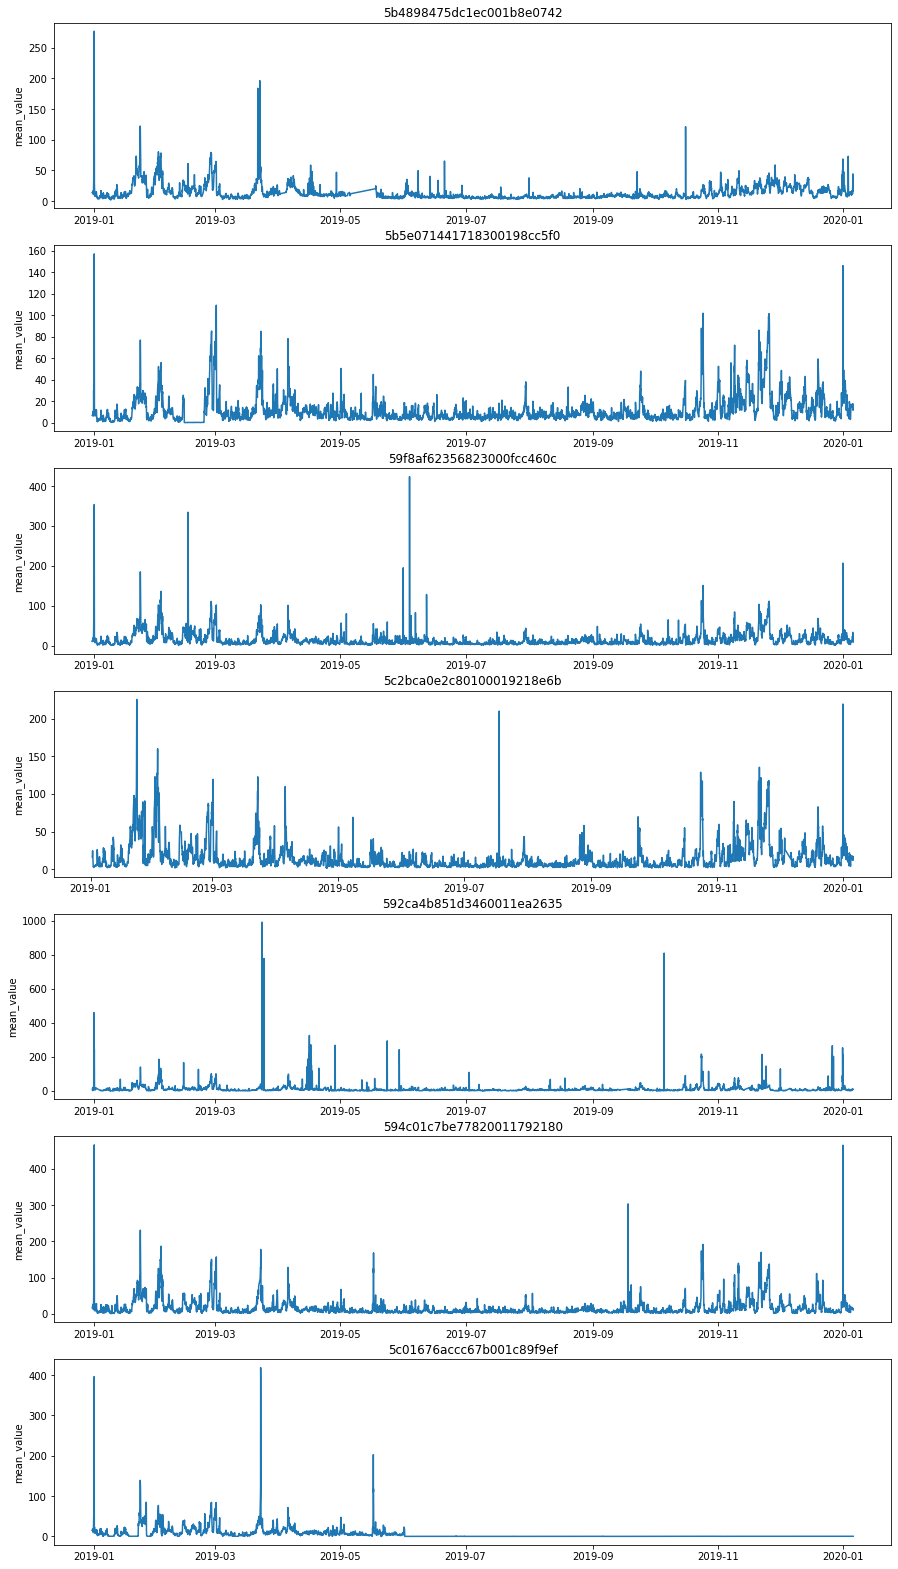

In [224]:
fig, ax = plt.subplots(len(boxes_berlin_df),1,figsize = (15,len(boxes_berlin_df)*4));

for ind in boxes_berlin_df.index:
    sns.lineplot(data = boxes_berlin_df.loc[ind,"PM10_values"],
                 x="time",
                 y="mean_value",
                 ax=ax[ind]);
    ax[ind].set(title = boxes_berlin_df.loc[ind,"box_id"],
                xlabel = "")





for the last one data for half of the year is missing, so we drop this box

In [226]:
boxes_berlin_df = boxes_berlin_df.loc[boxes_berlin_df.box_id != "5c01676accc67b001c89f9ef",]

### aggregate over boxes

In [281]:
agg_berlin_df = boxes_berlin_df.loc[0,"PM10_values"]

for ind in boxes_berlin_df.index:
    if ind > 0:
        agg_berlin_df = agg_berlin_df.merge(right = boxes_berlin_df.loc[ind,"PM10_values"],
                                            on = "time",
                                            how = "outer")

In [273]:
agg_berlin_df.isna().sum()

time              0
mean_value_x      0
mean_value_y      0
mean_value_x      2
mean_value_y    193
mean_value_x    321
mean_value_y    386
dtype: int64

In [282]:
agg_berlin_df["mean"] = agg_berlin_df.drop(columns = "time").apply(lambda x: np.mean(x),axis=1)
agg_berlin_df["median"] = agg_berlin_df.drop(columns = ["time","mean"]).apply(lambda x: np.median(x),axis=1)

In [283]:
agg_berlin_df = agg_berlin_df[["time","mean","median"]]

[Text(0.5, 0, ''), Text(0.5, 1.0, 'mean over the 6 berlin boxes')]

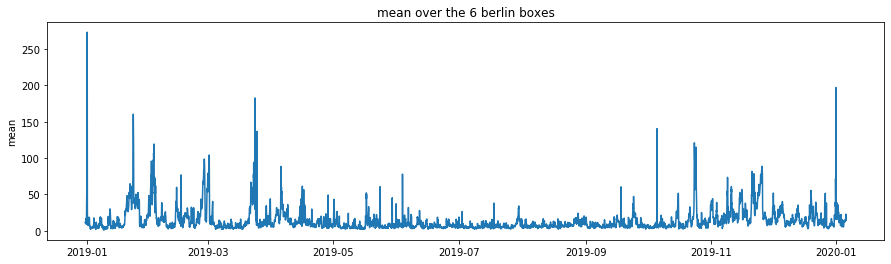

In [284]:
fig, ax = plt.subplots(figsize = (15,4));

sns.lineplot(data = agg_berlin_df,
                 x="time",
                 y="mean",
                 ax=ax);
ax.set(title = "mean over the 6 berlin boxes",
                xlabel = "")

## Save the data

In [286]:
boxes_berlin_df.to_pickle("data/6_boxes_berlin_2019.pkl")